In [26]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random 
from sklearn.metrics import mean_squared_error, mean_absolute_error
# from statsmodels.graphics.tsaplots import plot_acf

In [2]:
path = "../data/final_tables/erco/erco_train.csv"
df = pd.read_csv(path)

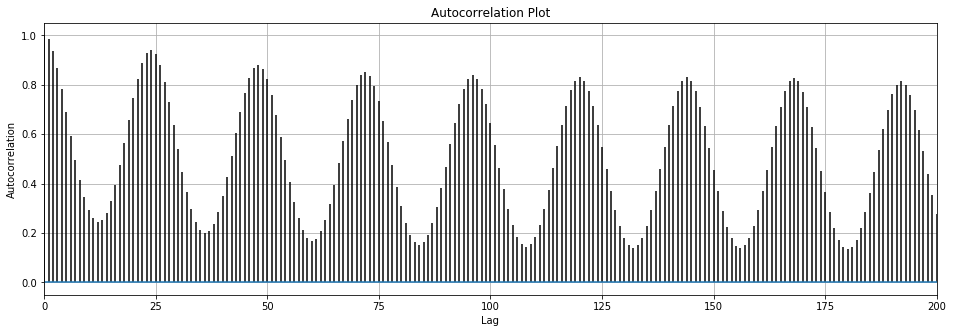

In [3]:
# Plotting the Autocorrelation plot.
data = df["Normalized Demand"]
lag=200
# Plot the autocorrelation
plt.figure(figsize=(16, 5))
plt.acorr(data, maxlags=lag, normed=True, usevlines=True)

# Adjust the plot to only show non-negative lags
plt.xlim([0, lag])

plt.title('Autocorrelation Plot')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.grid(True)

plt.show()

In [35]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np
from math import sqrt


class AR:
    def __init__(self, p):
        self.p = p
        self.model = LinearRegression()
        self.sigma = None

    #Function to calculate RMSE
    def rmse(self, y_true, y_pred):
        return np.sqrt(mean_squared_error(y_true, y_pred))

    # Function to calculate MAPE
    def mape(self, y_true, y_pred):
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

    def generate_train_x(self, data):
        # Number of rows in the output matrix
        rows = len(data) - self.p

        # Initialize the output matrix with ones
        # Each row will start with a 1, followed by p elements from the original array
        output_matrix = np.ones((rows, self.p + 1))

        for i in range(rows):
            # For each row, set the next p elements in reverse order starting from i+p
            output_matrix[i, 1:] = data[i : i + self.p][::-1]

        return output_matrix

    def generate_train_y(self, data):
        return data[self.p :]

    def fit(self, data):
        self.sigma = np.std(data)
        train_x = self.generate_train_x(data)
        train_y = self.generate_train_y(data)
        self.model.fit(train_x, train_y)

    def predict(self, data, num_preds):
        # Initialize the prediction set with the last p data points
        current_set = np.hstack(([1], data[-self.p :][::-1]))
        predictions = []

        for _ in range(num_preds):
            # Predict the next value
            next_pred = self.model.predict([current_set])[0]
            predictions.append(next_pred)

            # Update the current set for the next prediction
            current_set = np.hstack(([1], np.hstack((next_pred, current_set[1:-1]))))

        return predictions

    def validate(self, data, num_preds, mean, std):
        rmses = []
        preds = []
        actuals = []
        
        # Iterate through the data in steps of num_preds, starting from 0 up to len(data) - self.p - num_preds
        for i in range(0, len(data) - self.p - num_preds + 1, 24):
            # The current chunk to predict on
            current_chunk = data[i : i + self.p]
            # The actual future values to compare against
            actual_values = data[i + self.p : i + self.p + num_preds]
            # Predict the next num_preds values
            predictions = self.predict(current_chunk, num_preds)
            preds.extend(predictions)
            actuals.extend(actual_values)
        
        preds = np.array(preds)*std+mean
        actuals = np.array(actuals)*std+mean
        
        forecast_rmse = self.rmse(actuals, preds)
        forecast_mae = mean_absolute_error(actuals, preds)
        forecast_mape = self.mape(actuals, preds)
        
        return {"rmse": forecast_rmse, "mae": forecast_mae, "mape":forecast_mape}


In [36]:
np.arange(2,9)

array([2, 3, 4, 5, 6, 7, 8])

In [37]:
def train_and_validate(train_path, test_path, p=24, num_preds=24,save=False):
    mean=43559.141
    std=10010.903
    print("loading data...")
    data_train = pd.read_csv(train_path)
    data_test = pd.read_csv(test_path)
    data_train["Normalized Demand"] = (data_train["Demand (MWh)"] - mean)/std
    data_test["Normalized Demand"] = (data_test["Demand (MWh)"] - mean)/std
    
    data_train=data_train["Normalized Demand"]
    data_test=data_test["Normalized Demand"]

    ar = AR(p)
    print("AR constructed. Fitting...")
    ar.fit(data_train)
    print("Fitted. Validating...")
    rmse = ar.validate(data_test, num_preds=num_preds, mean=mean, std=std)
    print(f"average rmse: {rmse}")
    
    # Prepare the figure for a 3x2 subplot grid
    fig, axs = plt.subplots(3, 2, figsize=(15, 15))
    x_list_input=np.arange(p)
    x_list_preds=np.arange(p,p+num_preds)
    for i in range(3):
        for j in range(2):
            start_point = random.randint(0, len(data_test) - p - num_preds)
            test_chunk = data_test[start_point:start_point + p]
            actual_following = data_test[start_point + p:start_point + p + num_preds]

            # Adjust for the flatten index in subplots
            ax = axs[i, j]

            # Predict the next few time steps
            predictions = ar.predict(test_chunk, num_preds)

            # Adjust x-axis values to visualize continuity and distinction between the sequences
            x_input = range(start_point, start_point + p)
            x_preds = range(start_point + p, start_point + p + num_preds)

            # Plotting on the respective subplot
            ax.plot(x_list_input, test_chunk, 'b-', label='Input Chunk' if i+j == 0 else "", linewidth=2)
            ax.plot(x_list_preds, predictions, 'r--', label='Predictions' if i+j == 0 else "", linewidth=2)
            ax.plot(x_list_preds, actual_following, 'g-', label='Actual' if i+j == 0 else "", linewidth=2)

            # Include labels/legend in the first subplot only to avoid redundancy
            if i == 0 and j == 0:
                ax.legend()

    # Optional: Adjust layout for better fit
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    if save:
        plt.savefig("/Users/aidanwiteck/Desktop/Princeton/Year 4/Thesis/Homeworks/SpringInterimReport/armodel_preds.pdf", format="pdf", bbox_inches="tight")
    plt.show()

    return rmse

loading data...
AR constructed. Fitting...
Fitted. Validating...
average rmse: {'rmse': 2950.965258448769, 'mae': 2030.3892872886934, 'mape': 3.959411531799114}


/Users/aidanwiteck/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/Users/aidanwiteck/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:239: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
/Users/aidanwiteck/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/Users/aidanwiteck/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:239: FutureWarning: Support for multi-dimensional in

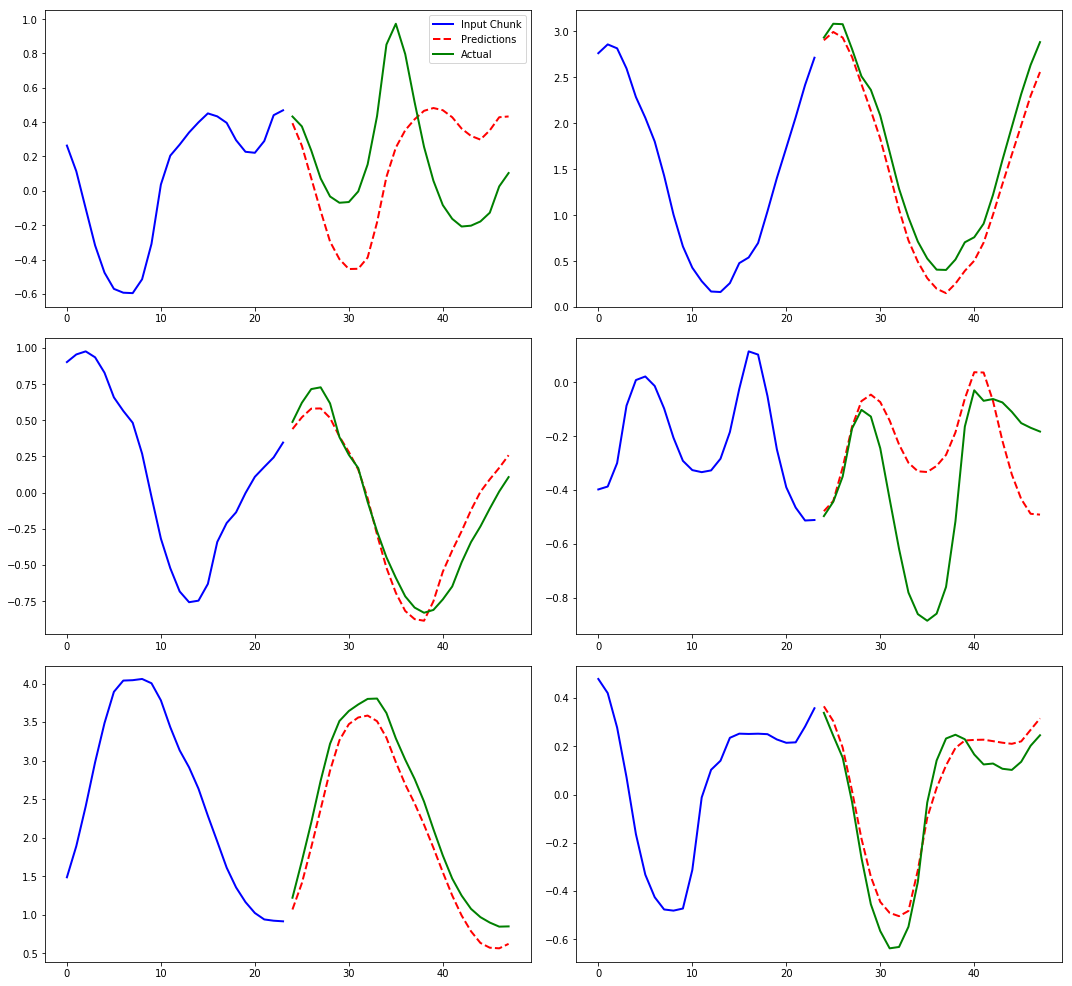

{'rmse': 2950.965258448769,
 'mae': 2030.3892872886934,
 'mape': 3.959411531799114}

In [38]:
train_path = "../data/final_tables/erco/erco_train.csv"
test_path = "../data/final_tables/erco/erco_test.csv"
train_and_validate(train_path, test_path, save=False)

loading data...
AR constructed. Fitting...
Fitted. Validating...
average rmse: {'rmse': 2950.965258448769, 'mae': 2030.3892872886934, 'mape': 3.959411531799114}


/Users/aidanwiteck/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/Users/aidanwiteck/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:239: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
/Users/aidanwiteck/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/Users/aidanwiteck/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:239: FutureWarning: Support for multi-dimensional in

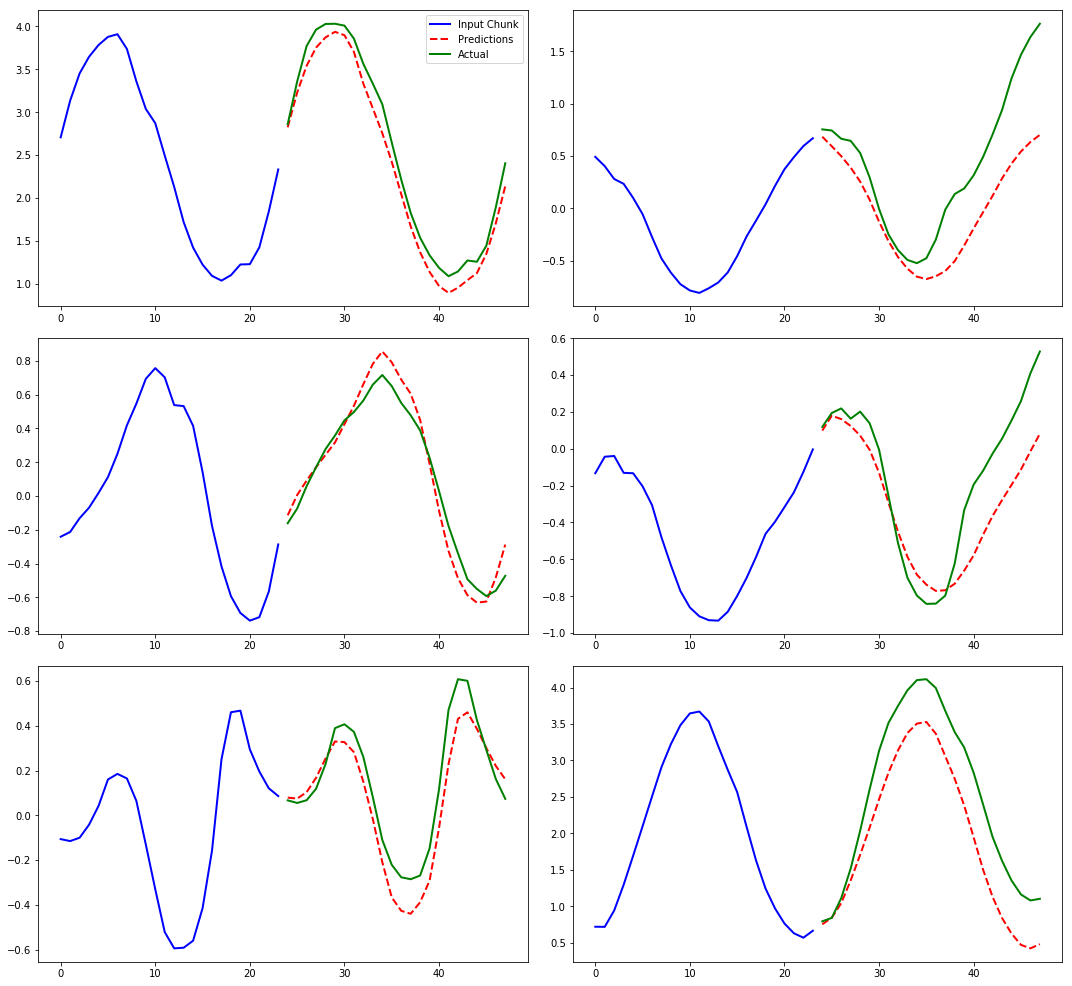

{'rmse': 2950.965258448769,
 'mae': 2030.3892872886934,
 'mape': 3.959411531799114}

In [44]:
train_and_validate(train_path, test_path,p=24, save=False)

In [20]:
t = pd.read_csv("../data/final_tables/erco/erco_train.csv")

t["Normalized Demand"] * std + mean

0        34247.011587
1        33452.692933
2        33053.628765
3        32728.853392
4        32692.661415
             ...     
61363    41077.771047
61364    40374.884755
61365    39220.551171
61366    38258.606518
61367    37152.846377
Name: Normalized Demand, Length: 61368, dtype: float64

In [21]:
t["Demand (MWh)"]

0        34680.0
1        33846.0
2        33427.0
3        33086.0
4        33048.0
          ...   
61363    41852.0
61364    41114.0
61365    39902.0
61366    38892.0
61367    37731.0
Name: Demand (MWh), Length: 61368, dtype: float64

In [22]:
np.mean(t["Demand (MWh)"]), np.std(t["Demand (MWh)"])

(43559.141034415334, 10010.903288936846)

loading data...
data loaded...
AR constructed. Fitting...
Fitted. Validating...
average rmse: 0.38739758128955165


/Users/aidanwiteck/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/Users/aidanwiteck/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:239: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
/Users/aidanwiteck/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/Users/aidanwiteck/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:239: FutureWarning: Support for multi-dimensional in

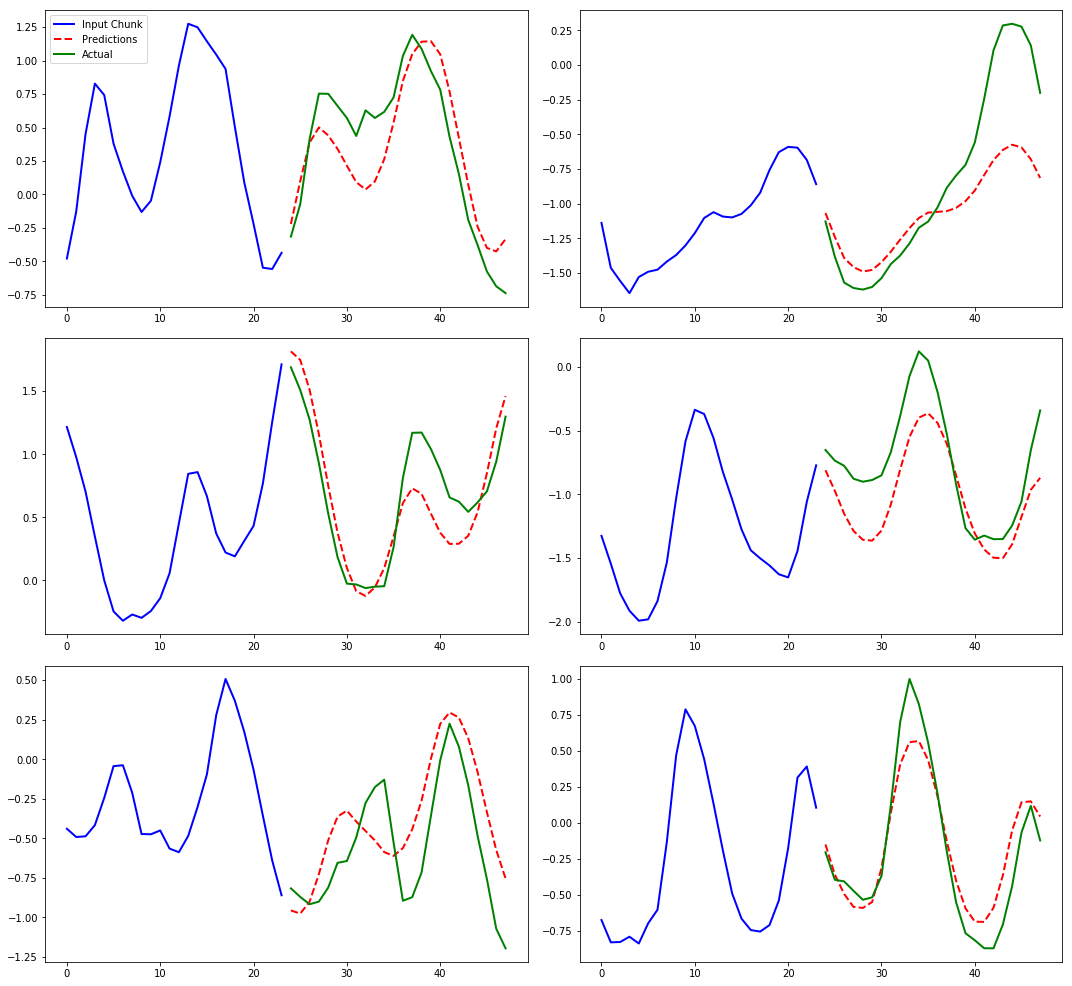

0.38739758128955165

In [9]:
train_and_validate(path, p=24, num_preds=24,save=True)